# Importing libraries

In [3]:
# Importing libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.utils import shuffle, class_weight
from sklearn.feature_extraction import FeatureHasher
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


# loading dataset

In [6]:
file_path = r"D:\minor project\DDOS Dataset.csv"
print("Loading dataset...")
df = pd.read_csv(file_path)
print(f"Original dataset size: {len(df)} rows, {len(df.columns)} columns")

Loading dataset...
Original dataset size: 15462150 rows, 26 columns


In [8]:
df = df.drop(columns=['flow_id', 'ip_src', 'ip_dst'], errors='ignore')

# Replace infinity with NaN and drop NaN rows

In [11]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
print(f"Dataset size after dropping NaN rows: {len(df)} rows")

Dataset size after dropping NaN rows: 2667523 rows


# Drop constant columns

In [14]:
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
if constant_columns:
    print(f"Dropping constant columns: {constant_columns}")
    df = df.drop(columns=constant_columns, inplace=False)

Dropping constant columns: ['idle_timeout', 'hard_timeout', 'FIN_Flag_Cnt', 'SYN_Flag_Cnt', 'RST_Flag_Cnt', 'PSH_Flag_Cnt', 'ACK_Flag_Cnt', 'URG_Flag_Cnt', 'CWE_Flag_Cnt', 'ECE_Flag_Cnt']


# Feature Hashing for high-cardinality columns

In [17]:
categorical_cols = ['flow_id', 'ip_src', 'ip_dst']
high_cardinality_cols = ['flow_id', 'ip_src']
existing_high_cardinality_cols = [col for col in high_cardinality_cols if col in df.columns]
if existing_high_cardinality_cols:
    hasher = FeatureHasher(n_features=5, input_type='string')
    hashed_features = hasher.transform(df[existing_high_cardinality_cols].astype(str).to_dict('records'))
    df_hashed = pd.DataFrame(hashed_features.toarray(), columns=[f'hash_{i}' for i in range(5)])
    df = df.drop(columns=existing_high_cardinality_cols)
    df = pd.concat([df, df_hashed], axis=1)
    print(f"Applied Feature Hashing to {existing_high_cardinality_cols}")
else:
    print("No high-cardinality categorical columns found in dataset.")

No high-cardinality categorical columns found in dataset.


# Scaling numeric features

In [20]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('label')
scaler = MinMaxScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
print(f"Number of numeric columns after preprocessing: {len(numeric_cols)}")
print(f"Numeric columns: {numeric_cols.tolist()}")

Number of numeric columns after preprocessing: 12
Numeric columns: ['timestamp', 'tp_src', 'tp_dst', 'ip_proto', 'flow_duration_sec', 'flow_duration_nsec', 'packet_count', 'byte_count', 'packet_count_per_second', 'packet_count_per_nsecond', 'byte_count_per_second', 'byte_count_per_nsecond']


# Encode labels if necessary

In [23]:
if df['label'].dtype == 'object':
    le = LabelEncoder()
    df['label'] = le.fit_transform(df['label'])

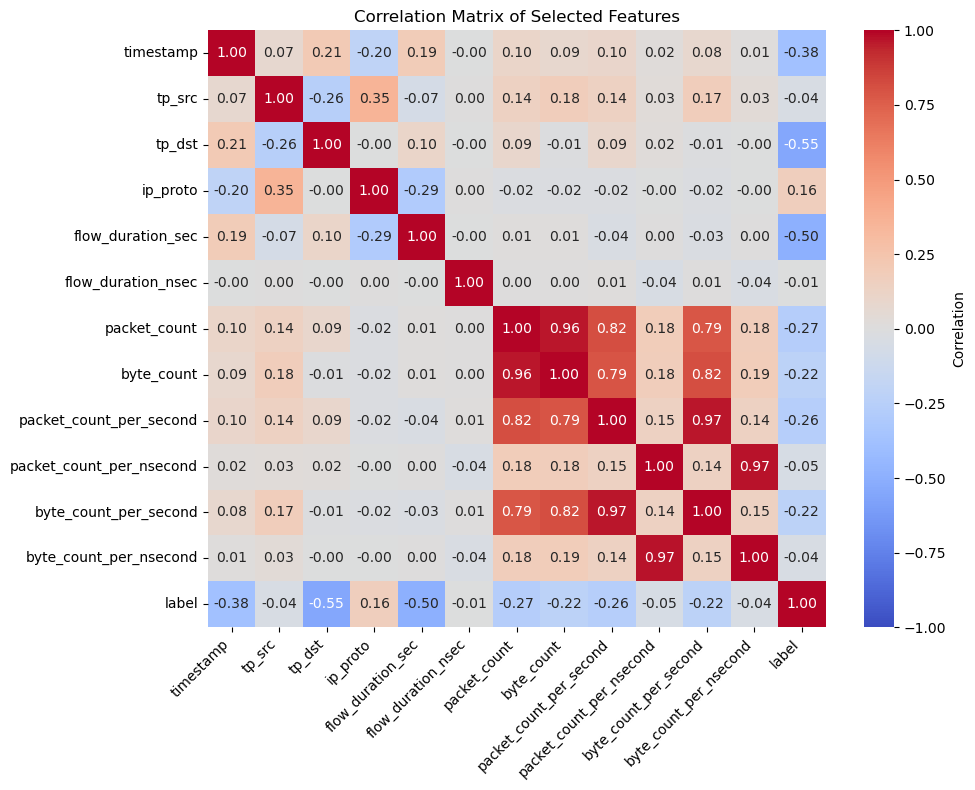

In [27]:
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, fmt='.2f', cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix of Selected Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Feature Selection based on Correlation

In [27]:
correlation_with_target = df.corr()['label'].drop('label')
correlation_threshold = 0.1
selected_features = correlation_with_target[abs(correlation_with_target) >= correlation_threshold].index.tolist()
dropped_features = correlation_with_target[abs(correlation_with_target) < correlation_threshold].index.tolist()
df = df[selected_features + ['label']]
print("\nSelected Features (Correlation >= 0.1):")
print(selected_features)
print("\nDropped Features (Correlation < 0.1):")
print(dropped_features)
print(f"\nFinal dataset shape after feature selection: {df.shape}")


Selected Features (Correlation >= 0.1):
['timestamp', 'tp_dst', 'ip_proto', 'flow_duration_sec', 'packet_count', 'byte_count', 'packet_count_per_second', 'byte_count_per_second']

Dropped Features (Correlation < 0.1):
['tp_src', 'flow_duration_nsec', 'packet_count_per_nsecond', 'byte_count_per_nsecond']

Final dataset shape after feature selection: (2667523, 9)


# randomize dataset shuffles dataset to remove order bias

In [30]:
df = shuffle(df, random_state=42)
print("Dataset randomized")

Dataset randomized


# Prepare features and target

In [33]:
X = df.drop(columns=['label']).values
y = df['label'].values
print(f"Shape of X after preprocessing: {X.shape}")

Shape of X after preprocessing: (2667523, 8)


# Split dataset

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {len(X_train)} rows, Test set size: {len(X_test)} rows")
print(f"Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}")

Training set size: 2134018 rows, Test set size: 533505 rows
Shape of X_train: (2134018, 8), Shape of X_test: (533505, 8)


# Compute class weights to handle imbalance

In [39]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

Class weights: {0: 1.470562130381392, 1: 0.7575826855121166}


# Reshape data for LSTM (samples, timesteps, features)

In [42]:
timesteps = 1  # Adjust based on data; using 1 for simplicity
X_train_reshaped = X_train.reshape((X_train.shape[0], timesteps, X_train.shape[1]))
X_test_reshaped = X_test.reshape((X_test.shape[0], timesteps, X_test.shape[1]))
print(f"Reshaped X_train: {X_train_reshaped.shape}, Reshaped X_test: {X_test_reshaped.shape}")

Reshaped X_train: (2134018, 1, 8), Reshaped X_test: (533505, 1, 8)


# Training Hybrid (ANN+LSTM) before combining adversial samples

In [3]:
# Training Hybrid ANN+LSTM Model
print("\nTraining Hybrid ANN+LSTM model...")
hybrid_model = Sequential([
    LSTM(64, input_shape=(timesteps, X_train.shape[1]), return_sequences=False, 
         kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
hybrid_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',
                     metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), 
                              tf.keras.metrics.Recall(name='recall')])

# Add early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


Training Hybrid ANN+LSTM model...


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# Training the model

In [7]:
# Train the model
hybrid_history = hybrid_model.fit(
    X_train_reshaped, y_train,
    epochs=5,
    batch_size=512,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)

Epoch 1/5
4169/4169 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.9693 - loss: 0.3783 - precision: 0.9674 - recall: 0.9867 - val_accuracy: 0.8316 - val_loss: 0.5038 - val_precision: 0.9816 - val_recall: 0.7591
Epoch 2/5
4169/4169 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.9864 - loss: 0.0878 - precision: 0.9849 - recall: 0.9945 - val_accuracy: 0.9556 - val_loss: 0.1465 - val_precision: 0.9854 - val_recall: 0.9467
Epoch 3/5
4169/4169 ━━━━━━━━━━━━━━━━━━━━ 36s 9ms/step - accuracy: 0.9878 - loss: 0.0822 - precision: 0.9864 - recall: 0.9951 - val_accuracy: 0.9918 - val_loss: 0.1045 - val_precision: 0.9878 - val_recall: 1.0000
Epoch 4/5
4169/4169 ━━━━━━━━━━━━━━━━━━━━ 35s 8ms/step - accuracy: 0.9878 - loss: 0.0812 - precision: 0.9866 - recall: 0.9950 - val_accuracy: 0.8315 - val_loss: 0.3205 - val_precision: 0.9815 - val_recall: 0.7591
Epoch 5/5
4169/4169 ━━━━━━━━━━━━━━━━━━━━ 36s 8ms/step - accuracy: 0.9881 - loss: 0.0787 - precision: 0.9870 - recall: 0.9951 - val_accuracy: 0.9905 - va

# Evaluate Hybrid Model on original dataset

In [9]:
# Evaluate Hybrid Model on original dataset
loss, accuracy, precision, recall = hybrid_model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"\nHybrid Model Test Loss: {loss:.4f}")
print(f"Hybrid Model Test Accuracy: {accuracy:.4f}")
print(f"Hybrid Model Test Precision: {precision:.4f}")
print(f"Hybrid Model Test Recall: {recall:.4f}")
y_pred_hybrid = (hybrid_model.predict(X_test_reshaped, verbose=0) > 0.5).astype("int32")
hybrid_f1 = f1_score(y_test, y_pred_hybrid)
print(f"Hybrid Model Test F1-Score: {hybrid_f1:.4f}")
hybrid_conf_matrix = confusion_matrix(y_test, y_pred_hybrid)
print("\nHybrid Model Confusion Matrix:")
print(hybrid_conf_matrix)


Hybrid Model Test Loss: 0.0596
Hybrid Model Test Accuracy: 0.9905
Hybrid Model Test Precision: 0.9858
Hybrid Model Test Recall: 1.0000
Hybrid Model Test F1-Score: 0.9929

Hybrid Model Confusion Matrix:
[[176216   5058]
 [     4 352227]]


# Defining GAN attack function for Adversarial Sample Generation

In [11]:
# GAN for Adversarial Sample Generation
def build_generator(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(X_train.shape[1], activation='tanh')  # Output same size as input features
    ])
    return model

def build_discriminator(input_dim):
    model = Sequential([
        Dense(512, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(256, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model

# Build GAN model compile GAN

In [35]:
# Build and compile GAN
noise_dim = 200
generator = build_generator(noise_dim)
discriminator = build_discriminator(X_train.shape[1])
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Build GAN model
discriminator.trainable = False
gan_input = Input(shape=(noise_dim,))
generated_sample = generator(gan_input)
gan_output = discriminator(generated_sample)
gan = Model(gan_input, gan_output)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

D:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  # Train Discriminator and Train Generator

In [37]:
def train_gan(generator, discriminator, gan, X_train, epochs=5, batch_size=256):  # Reduced from 10 to 5 epochs
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_samples = X_train[idx]
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        fake_samples = generator.predict(noise, verbose=0)
        
        d_loss_real = discriminator.train_on_batch(real_samples, real)
        d_loss_fake = discriminator.train_on_batch(fake_samples, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # Train Generator
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        g_loss = gan.train_on_batch(noise, real)
        
        print(f"GAN Epoch {epoch+1}/{epochs} [D loss: {d_loss[0]:.4f}, acc: {d_loss[1]:.4f}] [G loss: {g_loss:.4f}]")
    
    return generator

print("\nTraining GAN to generate adversarial samples...")
generator = train_gan(generator, discriminator, gan, X_train, epochs=5, batch_size=256)


Training GAN to generate adversarial samples...


D:\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


GAN Epoch 1/5 [D loss: 0.6998, acc: 0.3799] [G loss: 0.7066]
GAN Epoch 2/5 [D loss: 0.6981, acc: 0.4198] [G loss: 0.7052]
GAN Epoch 3/5 [D loss: 0.6987, acc: 0.4083] [G loss: 0.7055]
GAN Epoch 4/5 [D loss: 0.6982, acc: 0.4144] [G loss: 0.7042]
GAN Epoch 5/5 [D loss: 0.6983, acc: 0.4125] [G loss: 0.7037]


# Generate adversarial samples with added noise

In [39]:
# Generate adversarial samples with added noise
num_adv_samples = X_test.shape[0]
noise = np.random.normal(0, 1, (num_adv_samples, noise_dim))
X_adv = generator.predict(noise, verbose=0)
# Add random noise to adversarial samples
noise_factor = 0.05  
X_adv += np.random.normal(0, noise_factor, X_adv.shape)
X_adv_reshaped = X_adv.reshape((X_adv.shape[0], timesteps, X_adv.shape[1]))
y_adv = y_test

# Evaluate Hybrid Model on adversarial dataset

In [41]:
# Evaluate Hybrid Model on adversarial dataset
loss_adv, accuracy_adv, precision_adv, recall_adv = hybrid_model.evaluate(X_adv_reshaped, y_adv, verbose=0)
print(f"\nHybrid Model Adversarial Test Loss: {loss_adv:.4f}")
print(f"Hybrid Model Adversarial Test Accuracy: {accuracy_adv:.4f}")
print(f"Hybrid Model Adversarial Test Precision: {precision_adv:.4f}")
print(f"Hybrid Model Adversarial Test Recall: {recall_adv:.4f}")
y_pred_hybrid_adv = (hybrid_model.predict(X_adv_reshaped, verbose=0) > 0.5).astype("int32")
hybrid_f1_adv = f1_score(y_adv, y_pred_hybrid_adv)
print(f"Hybrid Model Adversarial Test F1-Score: {hybrid_f1_adv:.4f}")
hybrid_conf_matrix_adv = confusion_matrix(y_adv, y_pred_hybrid_adv)
print("\nHybrid Model Adversarial Confusion Matrix:")
print(hybrid_conf_matrix_adv)


Hybrid Model Adversarial Test Loss: 5.7611
Hybrid Model Adversarial Test Accuracy: 0.4298
Hybrid Model Adversarial Test Precision: 0.6592
Hybrid Model Adversarial Test Recall: 0.2822
Hybrid Model Adversarial Test F1-Score: 0.3952

Hybrid Model Adversarial Confusion Matrix:
[[129873  51401]
 [252820  99411]]


# Combine original and adversarial data

In [43]:
# Combine original and adversarial data
print("\nCombining original and adversarial data...")
X_combined = np.concatenate([X_train, X_adv], axis=0)
y_combined = np.concatenate([y_train, y_adv], axis=0)
X_combined_reshaped = X_combined.reshape((X_combined.shape[0], timesteps, X_combined.shape[1]))
print(f"Shape of X_combined_reshaped: {X_combined_reshaped.shape}, Shape of y_combined: {y_combined.shape}")


Combining original and adversarial data...
Shape of X_combined_reshaped: (2667523, 1, 8), Shape of y_combined: (2667523,)


# Train Hybrid Model on combined dataset

In [49]:
# Train Hybrid Model on combined dataset
print("\nTraining Hybrid Model on combined dataset...")
hybrid_model_combined = Sequential([
    LSTM(32, input_shape=(timesteps, X_train.shape[1]), return_sequences=False,  # Reduced from 64 to 32
         kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),  
    Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Reduced from 128 to 64
    BatchNormalization(),
    Dropout(0.4),  
    Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Reduced from 64 to 32
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Reduced from 32 to 16
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])
hybrid_model_combined.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy',
                             metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), 
                                      tf.keras.metrics.Recall(name='recall')])
hybrid_history_combined = hybrid_model_combined.fit(
    X_combined_reshaped, y_combined,
    epochs=5, 
    batch_size=512,
    validation_data=(X_test_reshaped, y_test),
    callbacks=[early_stop],
    class_weight=class_weight_dict,
    verbose=1
)


Training Hybrid Model on combined dataset...


D:\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step - accuracy: 0.8556 - loss: 0.4729 - precision: 0.9010 - recall: 0.8776 - val_accuracy: 0.9806 - val_loss: 0.0904 - val_precision: 0.9715 - val_recall: 1.0000
Epoch 2/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8778 - loss: 0.2541 - precision: 0.9229 - recall: 0.8894 - val_accuracy: 0.9786 - val_loss: 0.1061 - val_precision: 0.9812 - val_recall: 0.9865
Epoch 3/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8788 - loss: 0.2519 - precision: 0.9252 - recall: 0.8883 - val_accuracy: 0.9852 - val_loss: 0.0769 - val_precision: 0.9780 - val_recall: 1.0000
Epoch 4/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8788 - loss: 0.2477 - precision: 0.9265 - recall: 0.8868 - val_accuracy: 0.9885 - val_loss: 0.0707 - val_precision: 0.9829 - val_recall: 1.0000
Epoch 5/5
5211/5211 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8812 - loss: 0.2492 - precision: 0.9236 - recall: 0.8942 - val_accuracy: 0.9844 - va

# Evaluate Hybrid Model on combined dataset (test set)

In [51]:
# Evaluate Hybrid Model on combined dataset (test set)
loss_combined, accuracy_combined, precision_combined, recall_combined = hybrid_model_combined.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"\nHybrid Model Combined Test Loss: {loss_combined:.4f}")
print(f"Hybrid Model Combined Test Accuracy: {accuracy_combined:.4f}")
print(f"Hybrid Model Combined Test Precision: {precision_combined:.4f}")
print(f"Hybrid Model Combined Test Recall: {recall_combined:.4f}")
y_pred_hybrid_combined = (hybrid_model_combined.predict(X_test_reshaped, verbose=0) > 0.5).astype("int32")
hybrid_f1_combined = f1_score(y_test, y_pred_hybrid_combined)
print(f"Hybrid Model Combined Test F1-Score: {hybrid_f1_combined:.4f}")
hybrid_conf_matrix_combined = confusion_matrix(y_test, y_pred_hybrid_combined)
print("\nHybrid Model Combined Confusion Matrix:")
print(hybrid_conf_matrix_combined)


Hybrid Model Combined Test Loss: 0.0707
Hybrid Model Combined Test Accuracy: 0.9885
Hybrid Model Combined Test Precision: 0.9829
Hybrid Model Combined Test Recall: 1.0000
Hybrid Model Combined Test F1-Score: 0.9914

Hybrid Model Combined Confusion Matrix:
[[175149   6125]
 [    17 352214]]


# Visualization of performane's , Confusion matrices & Roc curves

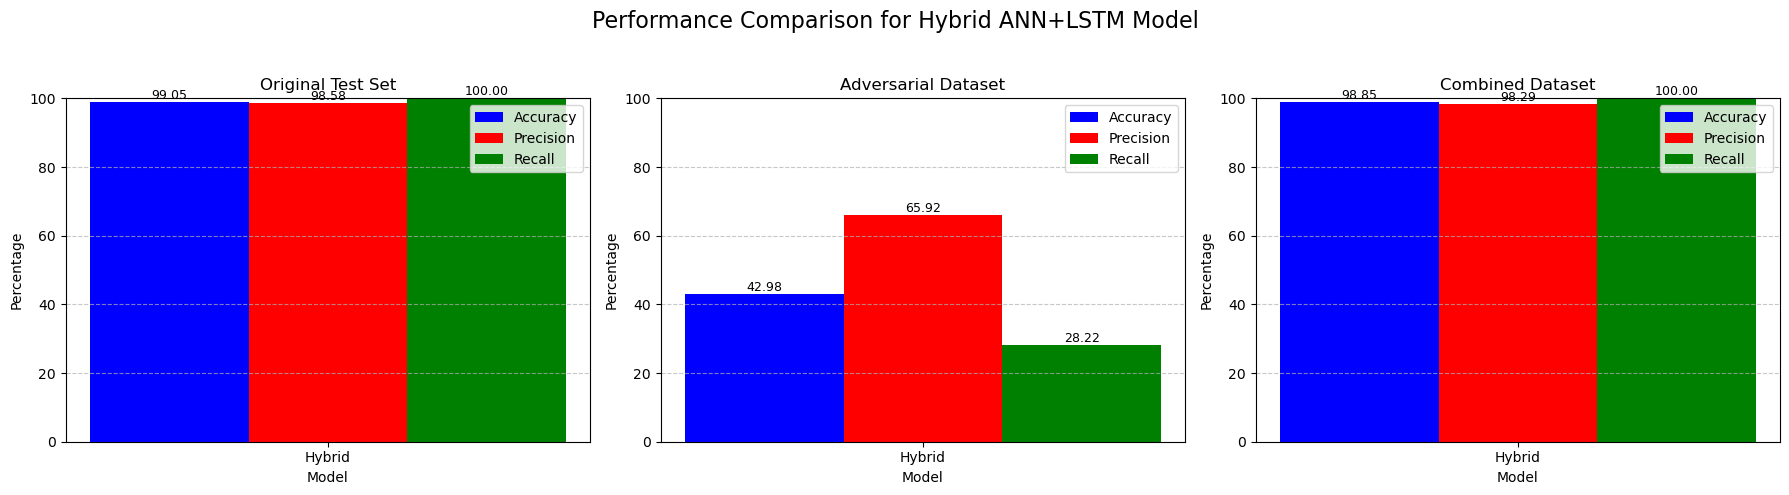

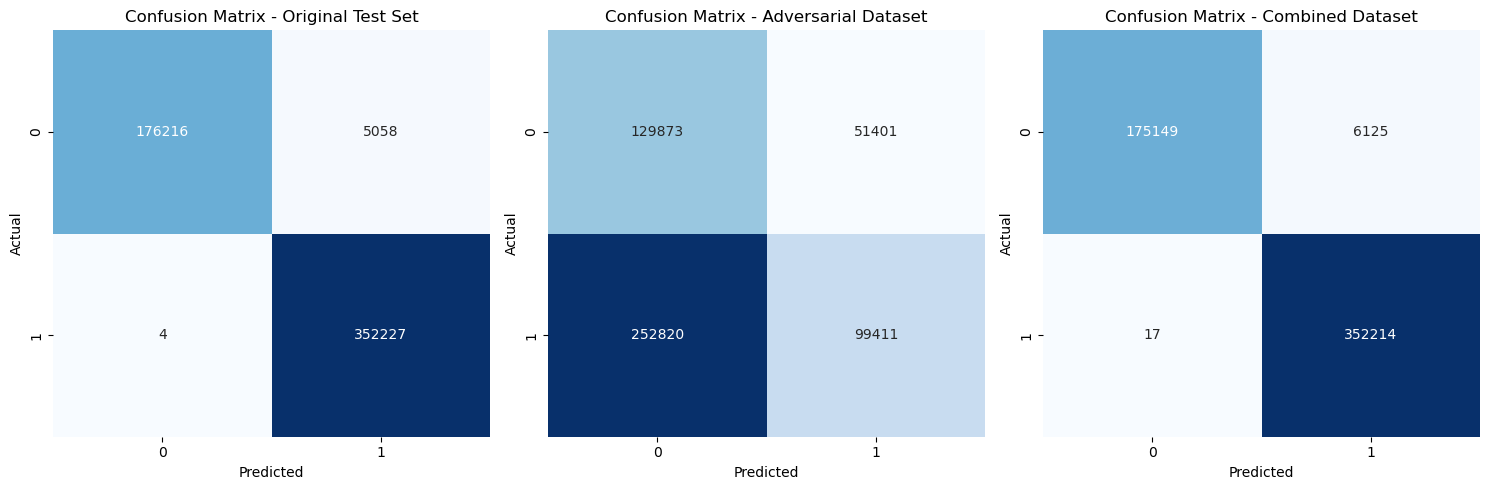

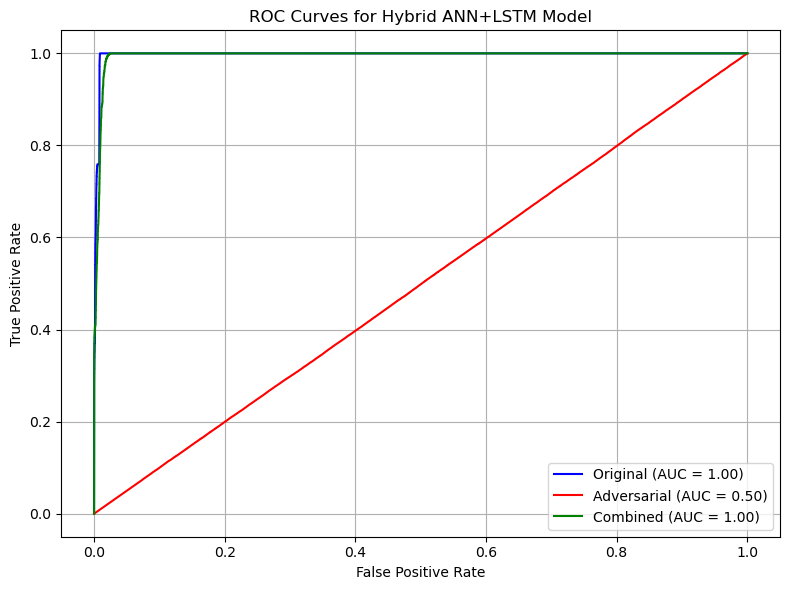

In [83]:
# Visualization
# Figure 1: Bar Plots
plt.figure(figsize=(18, 5))
plt.suptitle('Performance Comparison for Hybrid ANN+LSTM Model', fontsize=16)

# Original Test Set
accuracy_orig = accuracy_score(y_test, y_pred_hybrid) * 100
precision_orig = precision_score(y_test, y_pred_hybrid) * 100
recall_orig = recall_score(y_test, y_pred_hybrid) * 100

x = np.arange(1)
width = 0.2
plt.subplot(1, 3, 1)
bars1 = plt.bar(x - width, [accuracy_orig], width, label='Accuracy', color='blue')
bars2 = plt.bar(x, [precision_orig], width, label='Precision', color='red')
bars3 = plt.bar(x + width, [recall_orig], width, label='Recall', color='green')
plt.xlabel("Model")
plt.ylabel("Percentage")
plt.title("Original Test Set")
plt.xticks(x)
plt.xticks(x, ["Hybrid"])
plt.ylim(0, 100)
for bars, values in [(bars1, [accuracy_orig]), (bars2, [precision_orig]), (bars3, [recall_orig])]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adversarial Dataset
accuracy_adv = accuracy_score(y_adv, y_pred_hybrid_adv) * 100
precision_adv = precision_score(y_adv, y_pred_hybrid_adv) * 100
recall_adv = recall_score(y_adv, y_pred_hybrid_adv) * 100

plt.subplot(1, 3, 2)
bars1 = plt.bar(x - width, [accuracy_adv], width, label='Accuracy', color='blue')
bars2 = plt.bar(x, [precision_adv], width, label='Precision', color='red')
bars3 = plt.bar(x + width, [recall_adv], width, label='Recall', color='green')
plt.xlabel("Model")
plt.ylabel("Percentage")
plt.title("Adversarial Dataset")
plt.xticks(x)
plt.xticks(x, ["Hybrid"])
plt.ylim(0, 100)
for bars, values in [(bars1, [accuracy_adv]), (bars2, [precision_adv]), (bars3, [recall_adv])]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Combined Dataset
accuracy_combined = accuracy_score(y_test, y_pred_hybrid_combined) * 100
precision_combined = precision_score(y_test, y_pred_hybrid_combined) * 100
recall_combined = recall_score(y_test, y_pred_hybrid_combined) * 100

plt.subplot(1, 3, 3)
bars1 = plt.bar(x - width, [accuracy_combined], width, label='Accuracy', color='blue')
bars2 = plt.bar(x, [precision_combined], width, label='Precision', color='red')
bars3 = plt.bar(x + width, [recall_combined], width, label='Recall', color='green')
plt.xlabel("Model")
plt.ylabel("Percentage")
plt.title("Combined Dataset")
plt.xticks(x)
plt.xticks(x, ["Hybrid"])
plt.ylim(0, 100)
for bars, values in [(bars1, [accuracy_combined]), (bars2, [precision_combined]), (bars3, [recall_combined])]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{value:.2f}', ha='center', va='bottom', fontsize=9)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Figure 2: Confusion Matrices
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.heatmap(hybrid_conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Original Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 2)
sns.heatmap(hybrid_conf_matrix_adv, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Adversarial Dataset')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.subplot(1, 3, 3)
sns.heatmap(hybrid_conf_matrix_combined, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Combined Dataset')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# Figure 3: ROC Curves
plt.figure(figsize=(8, 6))

# Original Test Set ROC
y_pred_prob_hybrid = hybrid_model.predict(X_test_reshaped, verbose=0)
fpr_orig, tpr_orig, _ = roc_curve(y_test, y_pred_prob_hybrid)
auc_orig = roc_auc_score(y_test, y_pred_prob_hybrid)
plt.plot(fpr_orig, tpr_orig, label=f'Original (AUC = {auc_orig:.2f})', color='blue')

# Adversarial Dataset ROC
y_pred_prob_adv = hybrid_model.predict(X_adv_reshaped, verbose=0)
fpr_adv, tpr_adv, _ = roc_curve(y_adv, y_pred_prob_adv)
auc_adv = roc_auc_score(y_adv, y_pred_prob_adv)
plt.plot(fpr_adv, tpr_adv, label=f'Adversarial (AUC = {auc_adv:.2f})', color='red')

# Combined Dataset ROC
y_pred_prob_combined = hybrid_model_combined.predict(X_test_reshaped, verbose=0)
fpr_combined, tpr_combined, _ = roc_curve(y_test, y_pred_prob_combined)
auc_combined = roc_auc_score(y_test, y_pred_prob_combined)
plt.plot(fpr_combined, tpr_combined, label=f'Combined (AUC = {auc_combined:.2f})', color='green')

plt.title('ROC Curves for Hybrid ANN+LSTM Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()